# Projet 3 : Concevez une application au service de la santé publique
On aimerait faire une application qui aide à bien se nourrir, et qui donne du coup des nutriscores sur des plats
(On peut imaginer récupérer la recette d'un site de recettes, puis interroger openfoodfacts avec les éléments de la recette)
## Phase 1 : Nettoyage des données
### Import des librairies

In [1]:
# on commence par importer les dépendances dont on aura besoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
sns.set()

### Ajout de quelques fonctions utilitaires

In [2]:
# On aimerait connaitre le pourcentage de remplissage par colonne, pour enlever les colonnes très peu remplies
def get_NA_score(data):
    """
    Renvoie le pourcentage de remplissage par colonne
    
    Parameters
    ----------
    data: dataframe
    
    Returns
    -------
    df: dataframe avec le pourcentage de NA par colonne triéee par ordre de NA décroissant
    """
    null_sum = data.isnull().sum()
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100)).sort_values(ascending=False)
    percent_fill = ( 100.0 - percent).sort_values(ascending=False)
    
    df_NA = pd.concat([percent, percent_fill], axis=1, keys=['Percent NA', 'Fill Percent'], sort=True)
    
    return df_NA.sort_values('Percent NA', ascending=False)


# On aimerait enlever les doublons d'une dataframe en gardant juste les lignes les plus remplies
def remove_duplicates(data):
    """
    Renvoie la dataframe sans les doublons, en gardant la ligne la plus remplie
    
    Parameters
    ----------
    data: dataframe
    """
    
    data['temp_nb_nan'] = data.isnull().sum(axis=1)
    data.sort_values('temp_nb_nan', ascending=False, inplace=True)
    data.drop_duplicates(subset ="code", keep ='first', inplace = True)
    data.drop(columns='temp_nb_nan', inplace=True)    

def clean_wrong_values(df, columns_to_clean, min_value, max_value):
    """
    Remplace les colonnes pas dans l'intervalle min_value, max_value par None
    
    Parameters
    ----------
    df: dataframe
    columns_to_clean: colonnes à nettoyer
    min_value: valeur minimale valide
    max_value: valeur maximale valide
    """
    for column in columns_to_clean:
        df.loc[df[column] > max_value, column] = None
        df.loc[df[column] < min_value, column] = None
        
        
def drop_na_lines(df):
    """
    Enlève les lignes qui contiennent que des na à part pour le code, et le product_name
    
    Parameters
    ----------
    df: dataframe
    """    
    information_columns = [column for column in filtered_data.columns if column not in ['code', 'product_name']]
    df.dropna(subset=information_columns, inplace=True, how='all')

    
def plot_filling_rate(df, title):
    """
    Dessine le taux de remplissage de la dataframem 
    
    Parameters
    ----------
    df: dataframe
    title: titre du graphe
    """ 
    nb_nan = df.isnull().sum().sum()
    nb_non_nan = df.count().sum()
    nb_all = nb_nan + nb_non_nan
    
    fill_percent = nb_non_nan / nb_all;
    partition = [fill_percent, 1 - fill_percent]
    labels = ['Found data', 'Missing or wrong data']

    figure, ax = plt.subplots(figsize=(5, 5))
    plt.title(title, fontsize=15)
    ax.pie(partition,
           labels=labels,
           colors=['g', 'r'],
           autopct='%1.2f%%')


### Lecture des données depuis le CSV

In [3]:
# Les données sont séparée par une tabulation dans le csv faut le préciser 
# On a un warning sur des types mixtes pour certaines colonnes, faut activer le flag low_mermory=False
# le fichier met un peu de temps à télécharger, (il fait 2.10Go, on préfère le charger depuis une copie locale plutôt que de le charger en http)
raw_data = pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t', low_memory=False)

In [4]:
raw_data.shape

(1094562, 178)

In [5]:
# il existe 1094562 lignes et 178 colonnes
raw_data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


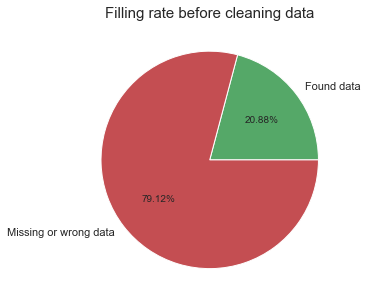

In [6]:
# on regarde le taux de remplissage de la dataframe
plot_filling_rate(raw_data, 'Filling rate before cleaning data')

### Nettoyage des colonnes

In [7]:
score_NA_data = get_NA_score(raw_data)
score_NA_data.head(30)

,Percent NA,Fill Percent
allergens_en,100.000000,0.000000
cities,100.000000,0.000000
ingredients_from_palm_oil,100.000000,0.000000
ingredients_that_may_be_from_palm_oil,100.000000,0.000000
-nervonic-acid_100g,100.000000,0.000000
-melissic-acid_100g,100.000000,0.000000
-mead-acid_100g,100.000000,0.000000
-lignoceric-acid_100g,100.000000,0.000000
no_nutriments,100.000000,0.000000
-erucic-acid_100g,100.000000,0.000000


In [8]:
# on remarque déjà beaucoup de colonnes très peu remplies
score_NA_data.tail(30)

,Percent NA,Fill Percent
image_ingredients_url,45.984604,54.015396
brands_tags,42.796114,57.203886
brands,42.791546,57.208454
energy-kcal_100g,27.352311,72.647689
image_small_url,24.606464,75.393536
image_url,24.606464,75.393536
saturated-fat_100g,23.616844,76.383156
sugars_100g,22.184582,77.815418
sodium_100g,22.174715,77.825285
salt_100g,22.170055,77.829945


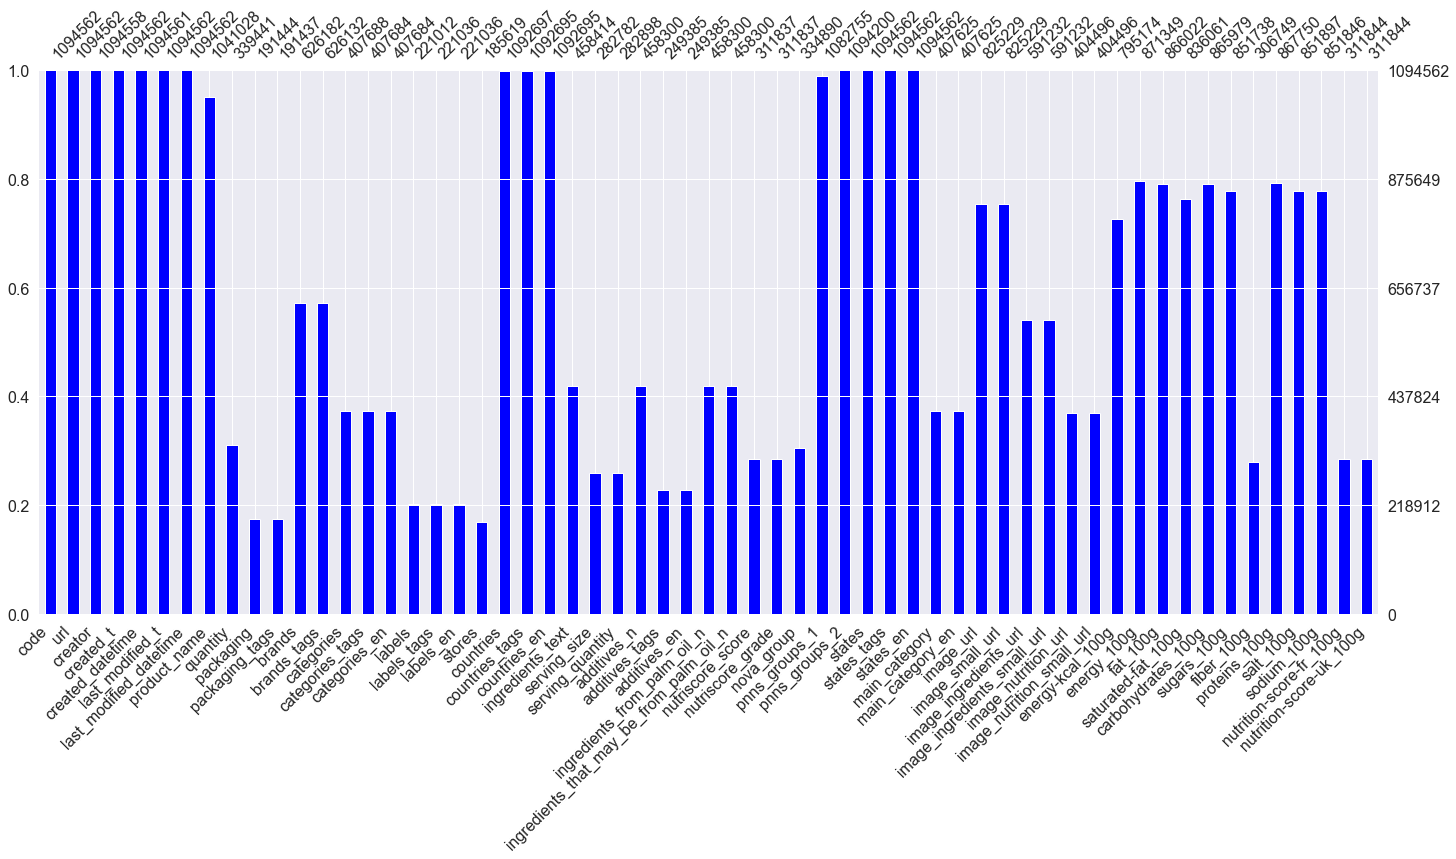

In [9]:
# les informations remplies à 100% sont surtout les métadonnées, les informations nutritionelles sont pas tout le temps remplies
# à 100%
# On préfère garder just les colonnes remplies à au moins 15%
filtered_data = msno.nullity_filter(raw_data, filter='top', p=0.15) 
msno.bar(filtered_data, labels=True, color='blue')

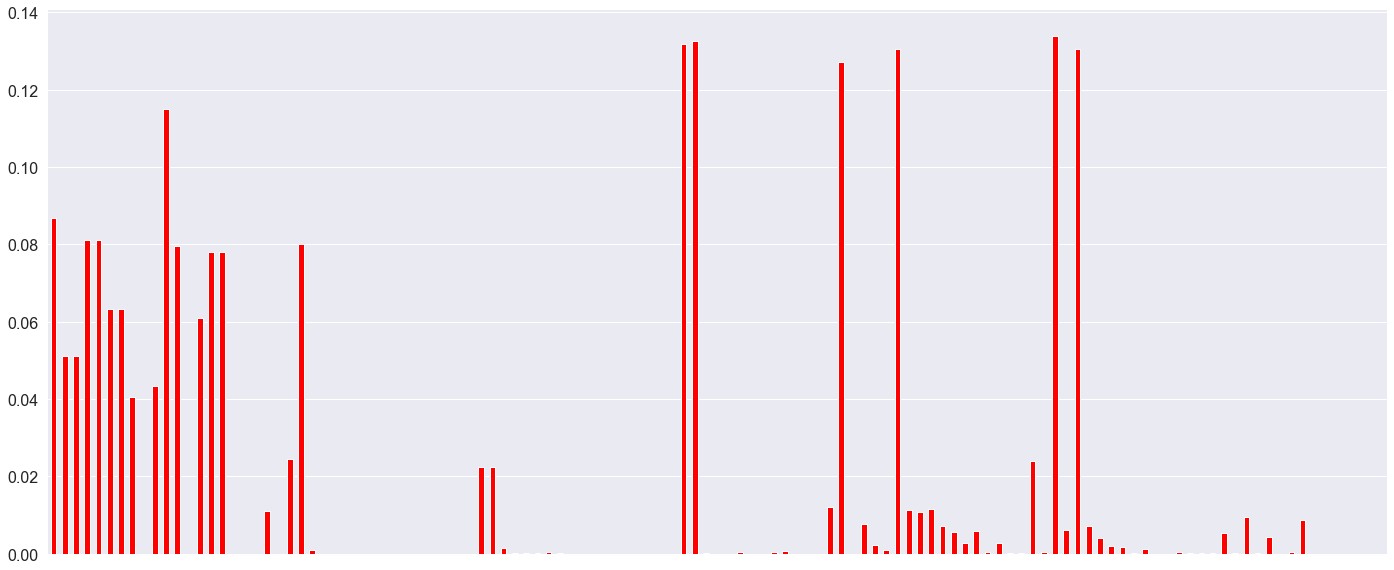

In [10]:
# on a donc mettre de côté les autres colonnes (on va juste regarder à quoi ressemple leur temps de remplissage sans garder les labels)
low_data = msno.nullity_filter(raw_data, filter='bottom', p=0.15) 
msno.bar(low_data, labels=False, color='red')

In [11]:
# Regardons la liste des colonnes existantes
for col in filtered_data.columns:
    print(col)

code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
quantity
packaging
packaging_tags
brands
brands_tags
categories
categories_tags
categories_en
labels
labels_tags
labels_en
stores
countries
countries_tags
countries_en
ingredients_text
serving_size
serving_quantity
additives_n
additives_tags
additives_en
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n
nutriscore_score
nutriscore_grade
nova_group
pnns_groups_1
pnns_groups_2
states
states_tags
states_en
main_category
main_category_en
image_url
image_small_url
image_ingredients_url
image_ingredients_small_url
image_nutrition_url
image_nutrition_small_url
energy-kcal_100g
energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
fiber_100g
proteins_100g
salt_100g
sodium_100g
nutrition-score-fr_100g
nutrition-score-uk_100g


In [12]:
# On a identifié des colonnes contenant des informations sur la création de la donnée dans la base, on peut les enlever
# on peut enlever toutes les métadonnées sur l'image du produit, les labels, les endroits ou ça été fabriqué 
columns_to_keep = [
'code',
'product_name',
'nutriscore_score',
'nutriscore_grade',
'energy-kcal_100g',
'energy_100g',
'fat_100g',
'saturated-fat_100g',
'carbohydrates_100g',
'sugars_100g',
'fiber_100g',
'proteins_100g',
'salt_100g',
'sodium_100g',
'nutrition-score-fr_100g',
'nutrition-score-uk_100g'
]

In [13]:
filtered_data = filtered_data[columns_to_keep]
filtered_data.shape

(1094562, 16)

In [14]:
# Il nous reste 16 colonnes, des 178 initiales, elles contiennent des information nutritionelles comme le nutrition score 
# dont on a besoin pour notre application, donc jusqu'ici l'application a l'air faisable


### Nettoyage des lignes

In [15]:
# On va maintenant regarder les lignes en duplicates 
duplicates = filtered_data['code'].duplicated(keep=False)
filtered_data[duplicates]

,code,product_name,nutriscore_score,nutriscore_grade,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
16138,0016000459335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16139,0016000459335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19189,0019320001376,0.75 oz Nabisco Airplane Cookies - Honey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
19190,0019320001376,0.75 oz Nabisco Airplane Cookies - Honey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74396,0051500006962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077449,8901262260152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077947,8904063240026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077948,8904063240026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1091284,9415142005904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# il existe 376 lignes en double (en utilisant le code produit)
# On va enlever les lignes en double, en gardant juste celles qui sont le plus remplies
remove_duplicates(filtered_data)
filtered_data.shape


(1094374, 16)

In [17]:
# On va nettoyer les lignes qui ne contiennent aucune information pertinante, en effet, si on a que le code 
# le nom du produit on peut pas en faire grand chose pour déterminer la qualité d'un plat
information_columns = [column for column in filtered_data.columns if column not in ['code', 'product_name']]
filtered_data.dropna(subset=information_columns, inplace=True, how='all')

filtered_data.shape

(879459, 16)

In [18]:
# regardons maintenant les colonnes exprimées pour 100G
columns_in_100g = [column for column in filtered_data.columns if column.endswith('100g')]
columns_in_100g

['energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

In [19]:
# ces colonnes sont pour la majorité exprimées en grammes pour 100g
# le nutriscore est particulier, c'est un score entre -15 et 40 information d'après https://nutriscore.blog/
columns_in_100g.remove('nutrition-score-fr_100g')
columns_in_100g.remove('nutrition-score-uk_100g')
# l'energie étant exprimée en calories ou en joules, on la garde de côté aussi 
columns_in_100g.remove('energy-kcal_100g')
columns_in_100g.remove('energy_100g')

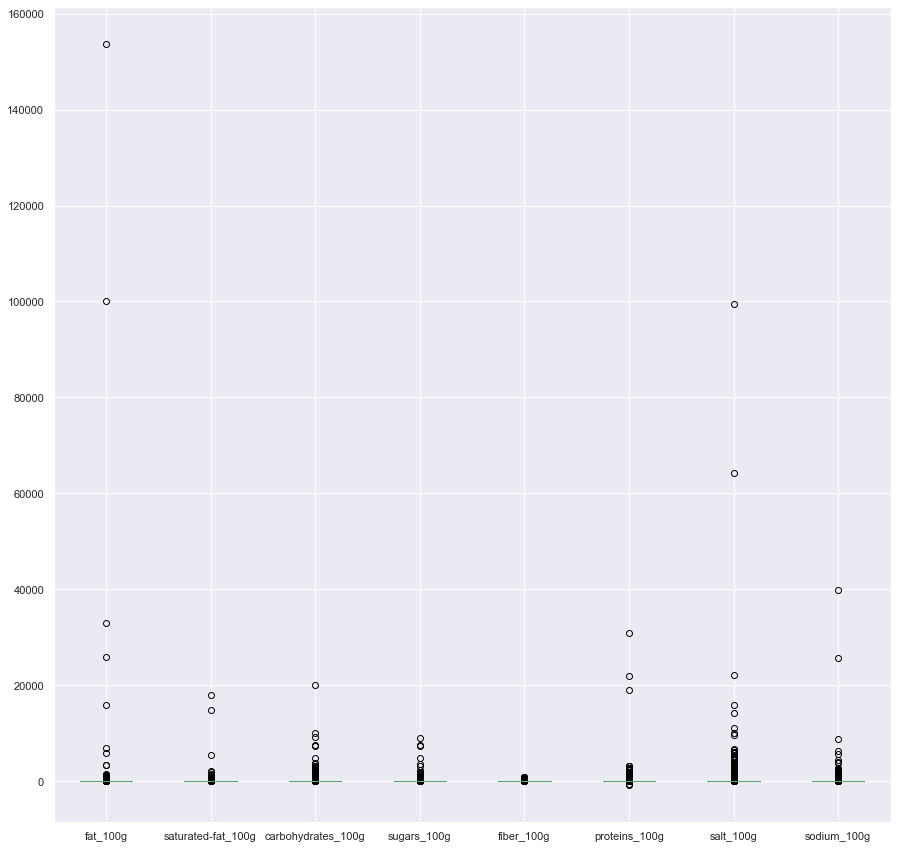

In [20]:
# Regardons maintenant la répartition des données pour 100g
filtered_data[columns_in_100g].plot(kind='box', figsize=[15, 15])

In [21]:
# là aussi, il y a beaucoup de valeurs au dessus de 100g, alors que ça devrait pas l'être si c'est exprimé par 100g d'aliment
# On choisit d'ignorer ces valeurs et de les remplacer par NaN
clean_wrong_values(filtered_data, columns_in_100g, 0, 100)
# et on enlève les lignes ne contenant aucune information intéressante
drop_na_lines(filtered_data)
filtered_data.shape

(879456, 16)

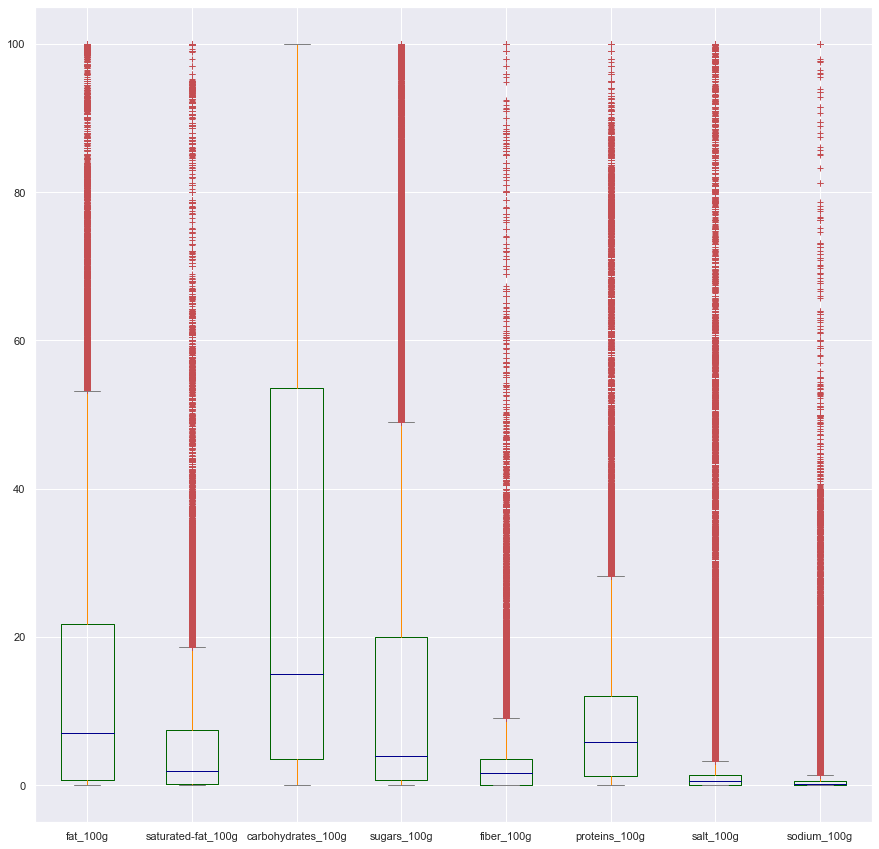

In [22]:
# Regardons encore une fois la répartition de ces données
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
filtered_data[columns_in_100g].plot(kind='box', figsize=[15, 15], color=color, sym='r+')

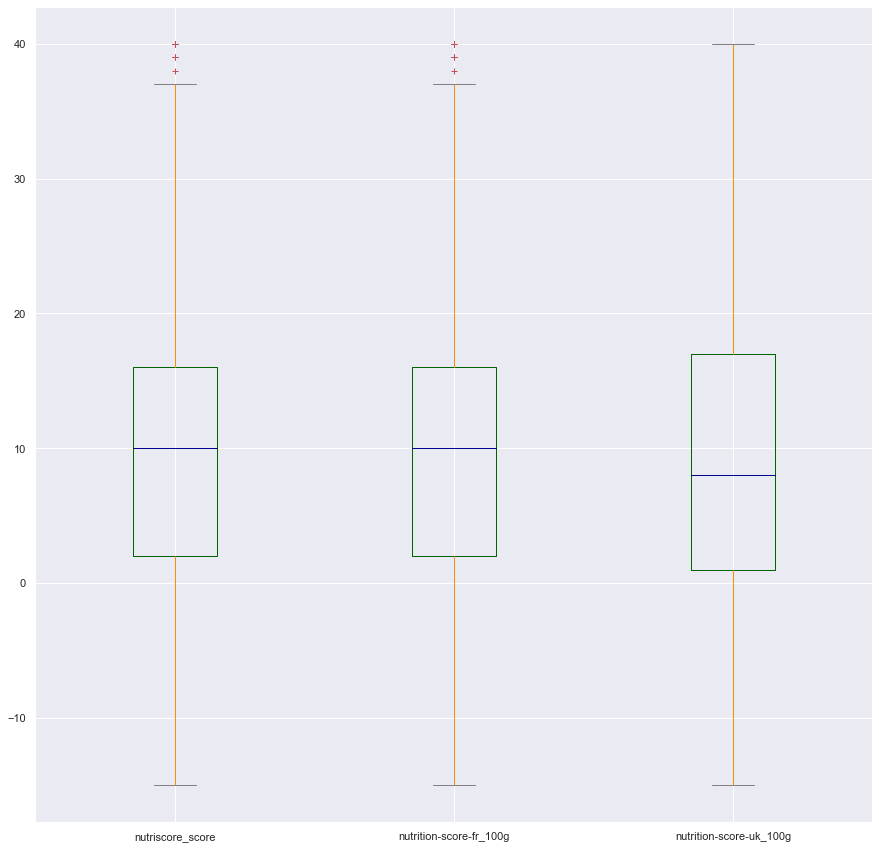

In [23]:
# on va vérifier aussi si les nutriscore respectent bien l'intervalle -15, 40
filtered_data[['nutriscore_score', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']].plot(kind='box', figsize=[15, 15], color=color, sym='r+')

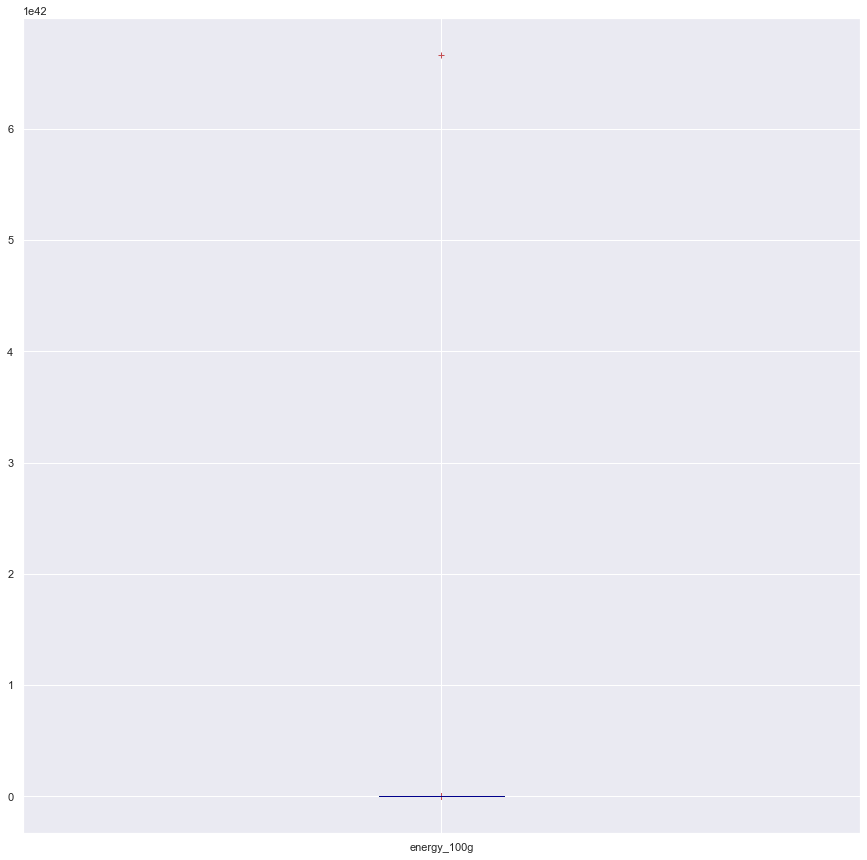

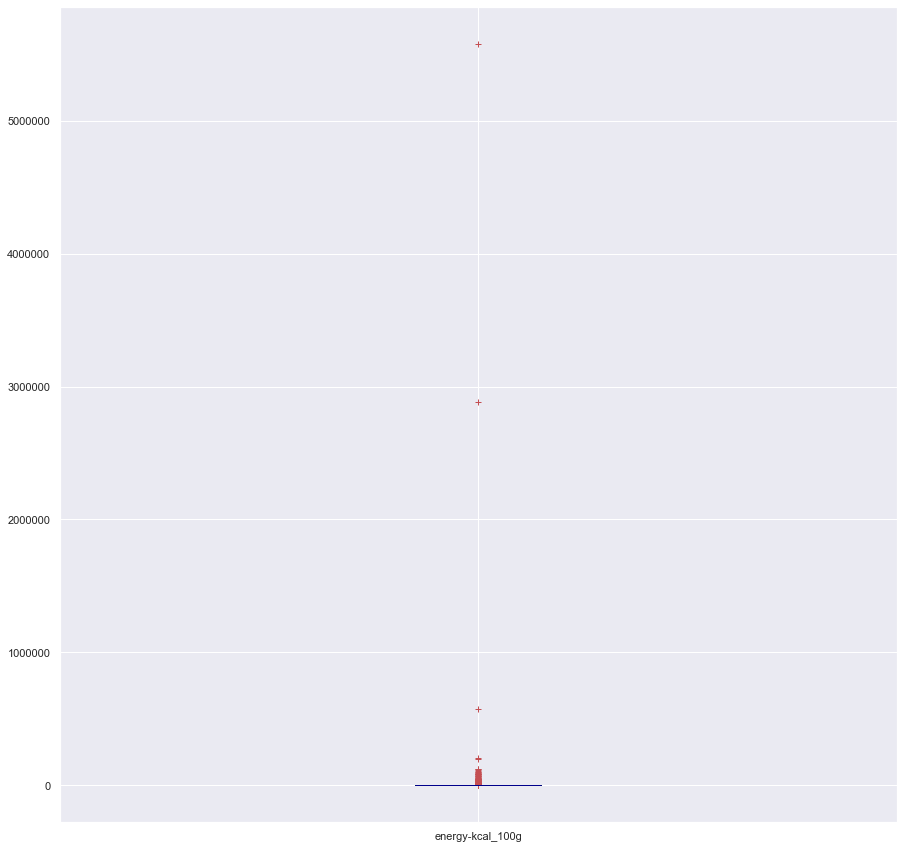

In [24]:
# Et on finit par les colonnes de l'énergie, qu'on aimerait aussi pouvoir utiliser
filtered_data[['energy_100g']].plot(kind='box', figsize=[15, 15], color=color, sym='r+')
filtered_data[['energy-kcal_100g']].plot(kind='box', figsize=[15, 15], color=color, sym='r+')

In [25]:
# energy-kcal_100g est exprimée en kcal
# Les aliments les plus caloriques sont les graisses à 900 kcal pour 100g on peut filrer les valeurs au dessus de 1000
clean_wrong_values(filtered_data, ['energy-kcal_100g'], 0, 1000)
# energy_100g est exprimé en kilo joules normalement
# 1000 kcal correspondent à 4200 kilo joules à peu près
clean_wrong_values(filtered_data, ['energy_100g'], 0, 4200)
# et on enlève les lignes ne contenant aucune information intéressante
drop_na_lines(filtered_data)
filtered_data.shape


(879426, 16)

## Analyse des différentes relations entres les colonnes

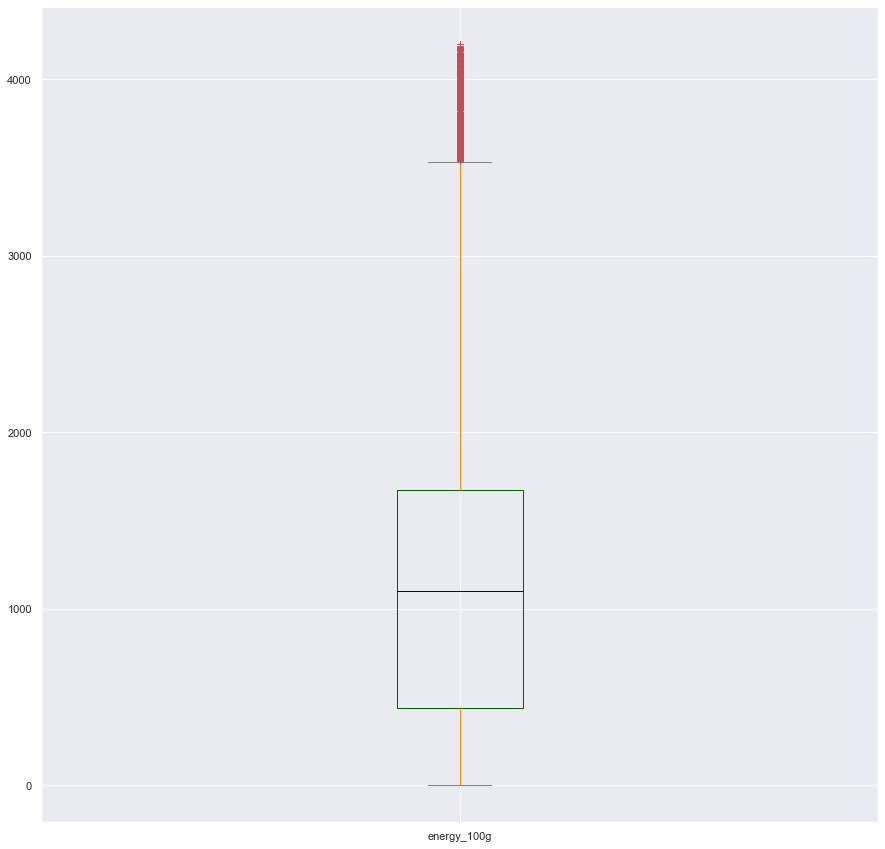

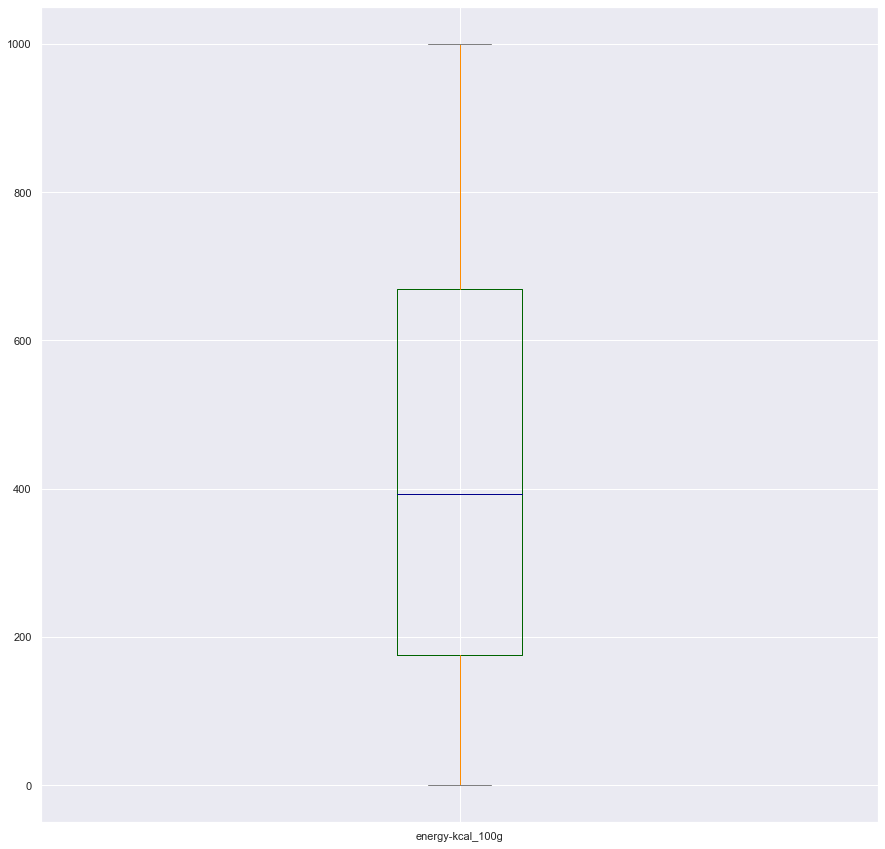

In [26]:
# et on regarde maintenant à quoi ressemplent les données
filtered_data[['energy_100g']].plot(kind='box', figsize=[15, 15], color=color, sym='r+')
filtered_data[['energy-kcal_100g']].plot(kind='box', figsize=[15, 15], color=color, sym='r+')

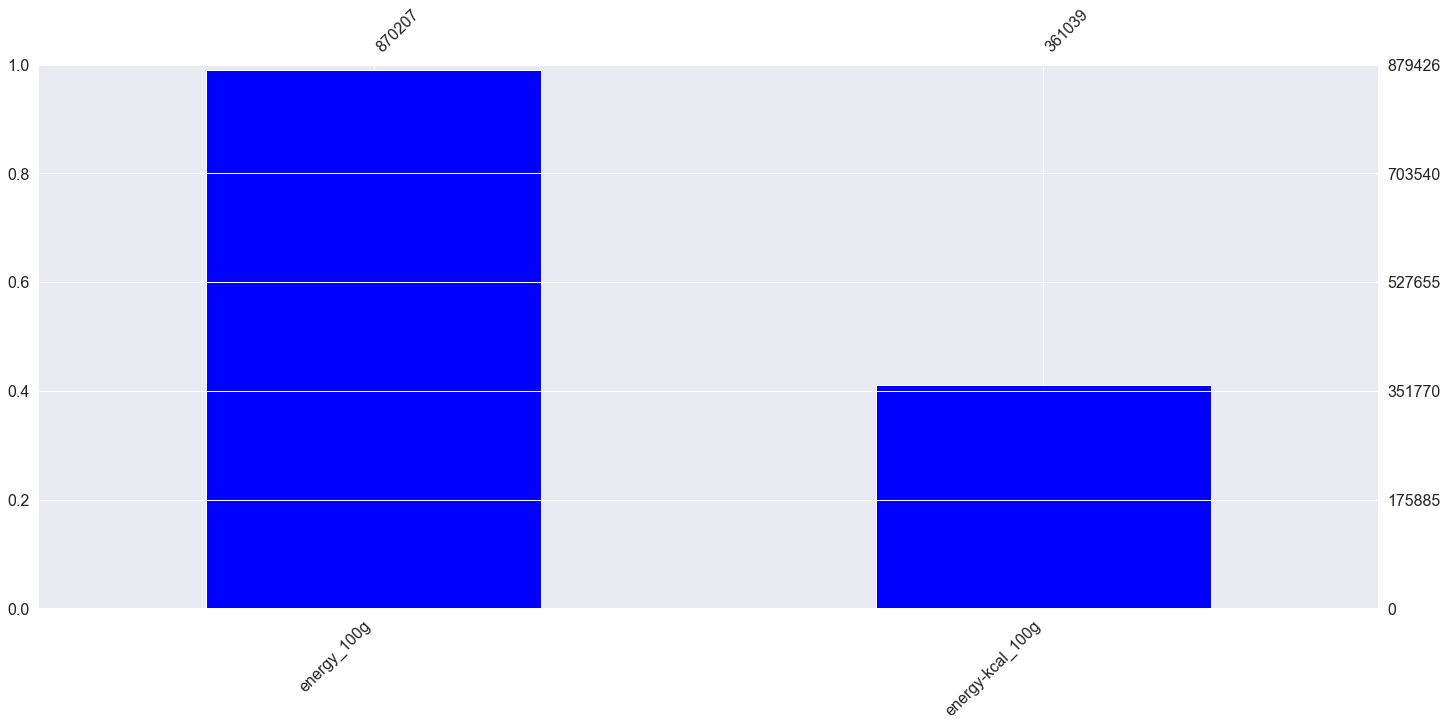

In [27]:
# l'énérgie est une information redondante, on veut garder qu'une seule des deux
msno.bar(filtered_data[['energy_100g', 'energy-kcal_100g']], labels=True, color='blue')
# regardons d'abord le temps de remplissage

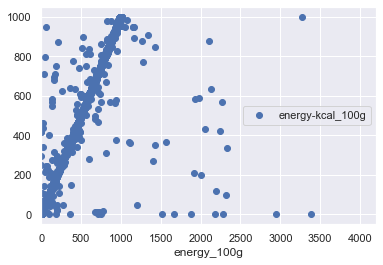

In [28]:
# on va aussi regarder la corrélation entre les deux colonnes
filtered_data.plot(x='energy_100g', y='energy-kcal_100g', style='o')

In [29]:
# on remarque droite avec une pente de 1 qui se dessine, ce qui est faux dans le cas réel, 
# 1Kcal, vaut 4,184 Kj
# Comme la relation est linéaire, on va plutôt garder la colonnes d'energy en 100g qui est beaucoup plus remplie
filtered_data.drop(columns='energy-kcal_100g', inplace=True)
# et on enlève les lignes ne contenant aucune information intéressante
drop_na_lines(filtered_data)
filtered_data.shape

(879426, 15)

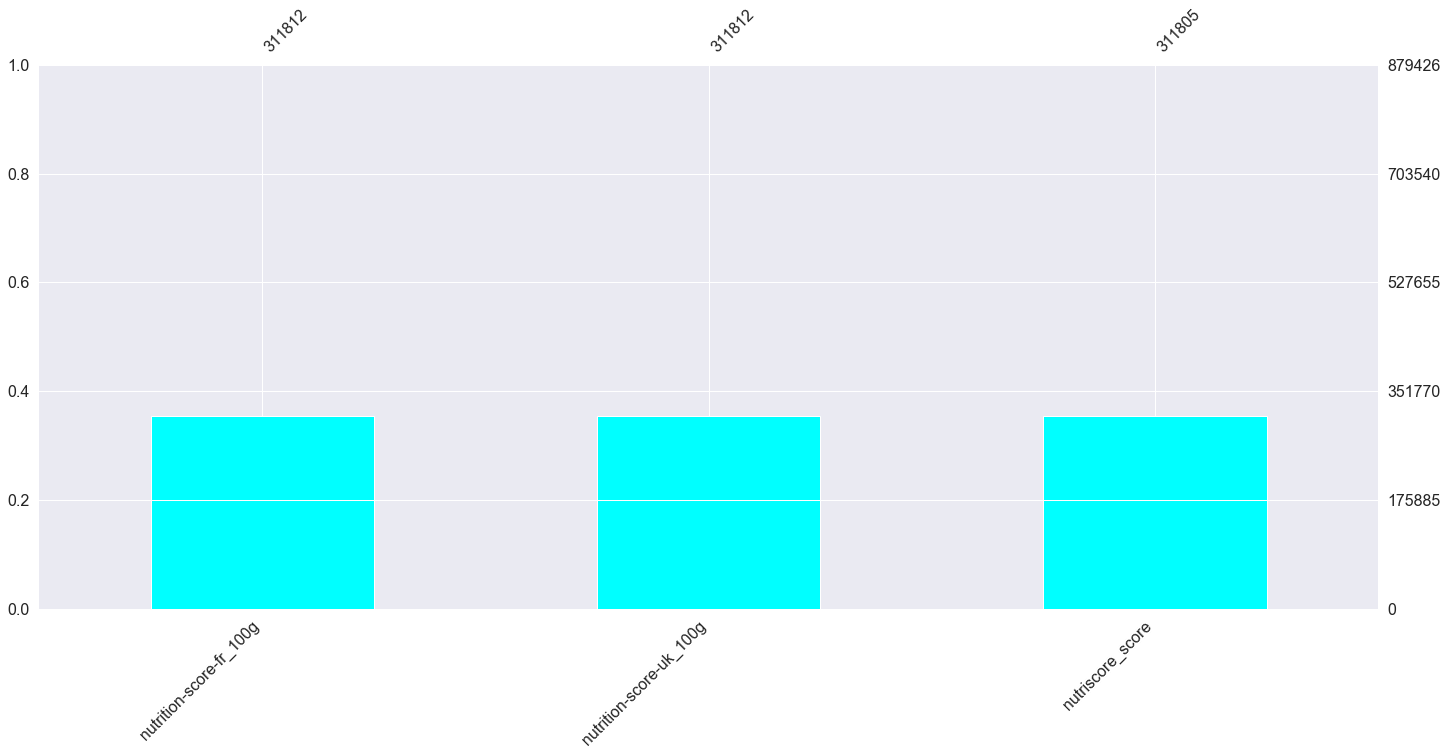

In [30]:
# on va à présent vérifier les nutrition score 
msno.bar(filtered_data[['nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'nutriscore_score']], labels=True, color='cyan')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


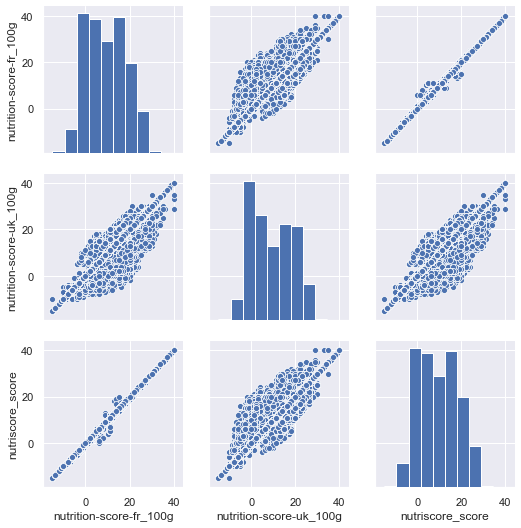

In [31]:
# les 3 nutritions scores possèdent le même taux de remplissage
# regardons les relations entre les 3
subset = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'nutriscore_score']
sns.pairplot(filtered_data[subset])

In [32]:
# On remarque que le nutriscore fr, est très lié au nutriscore (c'est la même chose dans la majorité des cas)
# le nutriscore uk, possède des différences, d'après https://world.openfoodfacts.org/data/data-fields.txt il est calculé différemment
# on va garder le nutriscore fr, vu qu'on veut plutôt faire une application destinée à la france
filtered_data.drop(columns=['nutrition-score-uk_100g', 'nutriscore_score'], inplace=True)

# et on enlève les lignes ne contenant aucune information intéressante
drop_na_lines(filtered_data)
filtered_data.shape

(879426, 13)

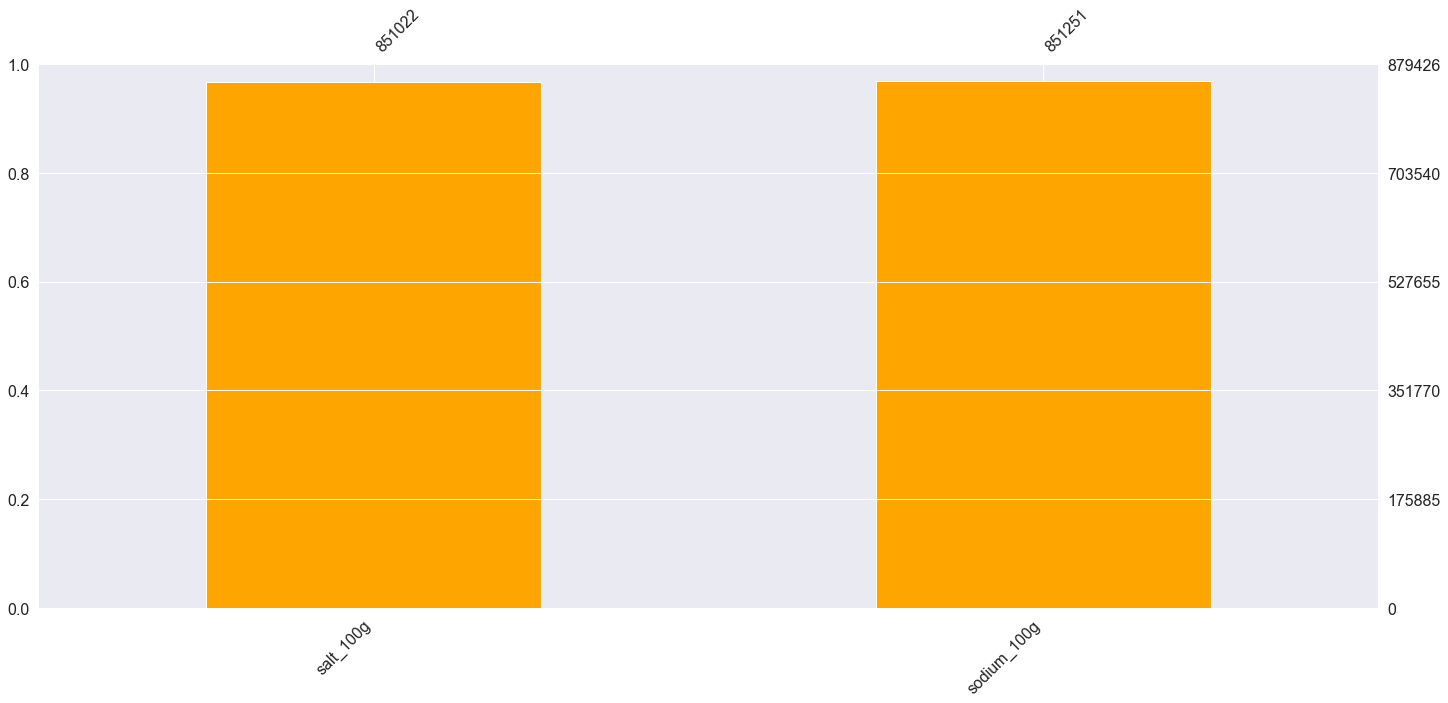

In [33]:
# De connaissance, le sodium et le sel sont très liés, vérifions ça
# On regarde le remplissage d'abord
msno.bar(filtered_data[['salt_100g', 'sodium_100g']], labels=True, color='orange')

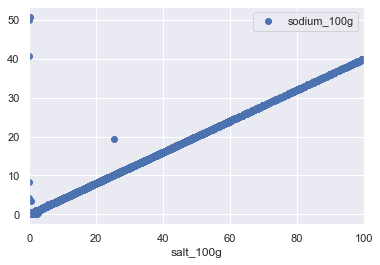

In [34]:
# on dessine le sodium en fonction du sel
filtered_data.plot(x='salt_100g', y='sodium_100g', style='o')


In [35]:
# ça semble correspondre à la réalité, en effet 100g de sel contiennent 38.758 grammes de sodium
# on peut enlever la colonne de sel légèrement moins remplie
filtered_data.drop(columns=['salt_100g'], inplace=True)
# et on enlève les lignes ne contenant aucune information intéressante
drop_na_lines(filtered_data)
filtered_data.shape

(879424, 12)

In [36]:
filtered_data.shape

(879424, 12)

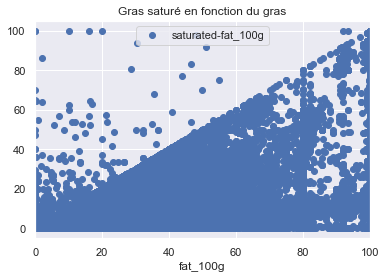

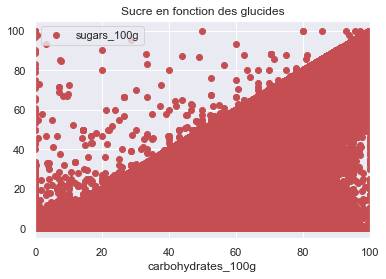

In [37]:
# les carbohydrates sont les glucides, ils sont censés inclure le sucre 
# pareil pour le fat, qui sont les lipides et qui sont censés inclure les satured fat (gras saturé)
# on va vérifier ça graphiquement
filtered_data.plot(x='fat_100g', y='saturated-fat_100g', style='bo', title='Gras saturé en fonction du gras')
filtered_data.plot(x='carbohydrates_100g', y='sugars_100g', style='ro', title='Sucre en fonction des glucides')

In [38]:
# Notre hypothèse semble vérifiée, on va enlever les colonnes pour lesquelles le gras saturé est supérieur au gras, 
# ou pour lesquelles la quantité de sucre est supérieure à celle des glucides

filtered_data.where(filtered_data['fat_100g'] >= filtered_data['saturated-fat_100g'], inplace=True)
filtered_data.where(filtered_data['carbohydrates_100g'] >= filtered_data['sugars_100g'] , inplace=True)
filtered_data.dropna(how='all', inplace=True)
filtered_data.shape

(823245, 12)

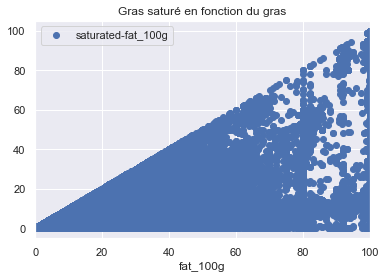

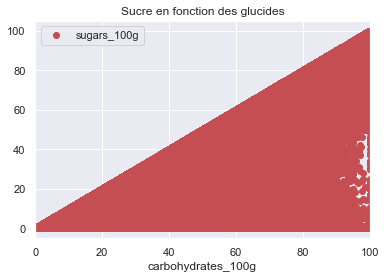

In [39]:
# On vérifie juste que nos graphes sont bien triangulaires maintenant
filtered_data.plot(x='fat_100g', y='saturated-fat_100g', style='bo', title='Gras saturé en fonction du gras')
filtered_data.plot(x='carbohydrates_100g', y='sugars_100g', style='ro', title='Sucre en fonction des glucides')

In [40]:
# finalement on va séparer ces colonnes en deux parties 
# la partie gras en gras saturé et non saturé, et la partie carbohydrates en glucides sans sucres et sucres 
for col in ['sugars_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'fat_100g']:
    filtered_data[col].fillna(0.0, inplace=True)
filtered_data['carbs_no_sugar_100g'] = filtered_data['carbohydrates_100g'] - filtered_data['sugars_100g']
filtered_data['fat_non_satu_100g'] = filtered_data['fat_100g'] - filtered_data['saturated-fat_100g']

# on supprime ce qui est de trop 
filtered_data.drop(columns=['carbohydrates_100g', 'fat_100g'], inplace=True)
# et on enlève les lignes ne contenant aucune information intéressante
drop_na_lines(filtered_data)
filtered_data.shape

(823245, 12)

In [41]:
# Les données pour l'instant ne sont pas très cohérente, on aimerait tout ramener à  une quantité en pourcent
# n'oublions pas qu'on a enlevé d'autres colonnes, donc la somme de ce qui nous reste n'est pas forcément égale à 100g
ingredients_columns = ['fat_non_satu_100g', 'carbs_no_sugar_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'saturated-fat_100g', 'sugars_100g']
for col in ingredients_columns:
    filtered_data[col].fillna(0.0, inplace=True)
filtered_data['temp_sum'] = filtered_data[ingredients_columns].sum(axis=1)
filtered_data.head()

,code,product_name,nutriscore_grade,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g,carbs_no_sugar_100g,fat_non_satu_100g,temp_sum
809561,5449000207357,Boisson à la Pulpe de Pêche,NaN,NaN,0.000000,12.200000,0.0,0.0,0.0,NaN,0.300000,0.000000,12.500000
651568,3760205500053,fleurs d'hibiscus naturelles,NaN,NaN,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000
894167,7750151002301,Leche Laive Vitaminizada,NaN,NaN,2.000000,4.000000,0.0,0.0,0.0,NaN,2.000000,2.000000,10.000000
722508,4305615416328,Molke Riegel,NaN,NaN,5.714286,5.714286,0.0,0.0,0.0,NaN,51.428571,5.714286,68.571429
679523,4002473802453,NaN,NaN,NaN,2.000000,1.400000,0.0,1.9,0.0,NaN,3.500000,2.600000,11.400000


In [42]:
# on enlève les lignes pourlesquelles la somme est <= 0 ou > 100
filtered_data.where(filtered_data['temp_sum'] > 0, inplace=True)
filtered_data.where(filtered_data['temp_sum'] <=100 , inplace=True)
filtered_data.dropna(subset=['temp_sum'], inplace=True)
filtered_data.shape

(788759, 13)

In [43]:
# on ramène tous les ingrédients en pourcent
for col in ingredients_columns:
    filtered_data[col] = 100 * filtered_data[col] / filtered_data['temp_sum']
filtered_data.head()

,code,product_name,nutriscore_grade,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g,carbs_no_sugar_100g,fat_non_satu_100g,temp_sum
809561,5449000207357,Boisson à la Pulpe de Pêche,NaN,NaN,0.000000,97.600000,0.0,0.000000,0.0,NaN,2.400000,0.000000,12.500000
894167,7750151002301,Leche Laive Vitaminizada,NaN,NaN,20.000000,40.000000,0.0,0.000000,0.0,NaN,20.000000,20.000000,10.000000
722508,4305615416328,Molke Riegel,NaN,NaN,8.333333,8.333333,0.0,0.000000,0.0,NaN,75.000000,8.333333,68.571429
679523,4002473802453,NaN,NaN,NaN,17.543860,12.280702,0.0,16.666667,0.0,NaN,30.701754,22.807018,11.400000
836684,6177322877888,bonbons cola,NaN,NaN,0.104058,0.520291,0.0,0.000000,0.0,NaN,99.375650,0.000000,96.100000


In [44]:
# et finalement on supprime cette colonne temporaire
filtered_data.drop(columns='temp_sum', inplace=True)
filtered_data.shape

(788759, 12)

In [45]:
# notre application veut le nutriscore , donc on enlève les lignes si ont trouve pas de nutriscore
filtered_data.dropna(subset=['nutrition-score-fr_100g'], inplace=True, how='all')
# et on enlève les lignes ne contenant aucune information intéressante
drop_na_lines(filtered_data)
filtered_data.shape


(302131, 12)

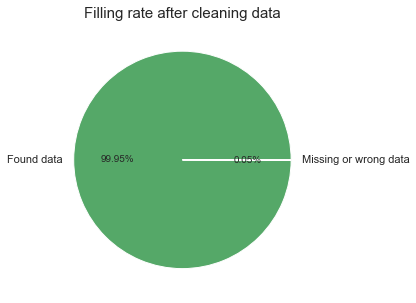

In [46]:
# on regarde maintenant de combien est notre taux de remplissage
plot_filling_rate(filtered_data, 'Filling rate after cleaning data')

In [47]:
# Enfin, pour le nutriscore, il a beaucoup de valeurs négatives, on aimerait justement le remettre en échelle pour pouvoir 
# avoir que des valeurs positives, on va créer un indicateur computed nutriscore qui va remettre ce score de 0 à 100
# Comme plus un produit est bon plus le nutriscore est faible, on va associer la note de 100, au nutriscore de -15, et 0 à 
# celui de 40
filtered_data['computed nutriscore fr'] = 100 * (40 - filtered_data['nutrition-score-fr_100g']) / 55 
filtered_data.head()

,code,product_name,nutriscore_grade,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g,carbs_no_sugar_100g,fat_non_satu_100g,computed nutriscore fr
806878,5425021250251,Filet de poulet sauce Chakchouka,NaN,481.0,1.204046,2.006743,0.0,23.679563,1.268261,1.0,58.195537,13.645850,70.909091
452448,327016058755,Fondant au Chocolat Surgelé,NaN,1732.0,22.085036,44.170072,0.0,8.834014,0.065212,22.0,13.803148,11.042518,32.727273
440376,3263851538918,Pointes d'asperges,NaN,67.0,0.000000,32.837750,0.0,46.520147,9.696186,-3.0,10.945917,0.000000,78.181818
521263,3428420053203,"Buche Creme au beurre, parfum chocolat",NaN,1594.0,19.203927,50.225655,0.0,6.795236,0.139580,22.0,11.817801,11.817801,32.727273
137120,010430652874676217,"Hackfleisch vom Rind und Schwein gemischt, zum...",NaN,1046.0,22.589452,0.000000,0.0,47.280248,0.186143,11.0,0.000000,29.944157,52.727273


Text(0.5, 1.05, 'Nutriscore calculé (de 0 mauvaise note, à 100)')

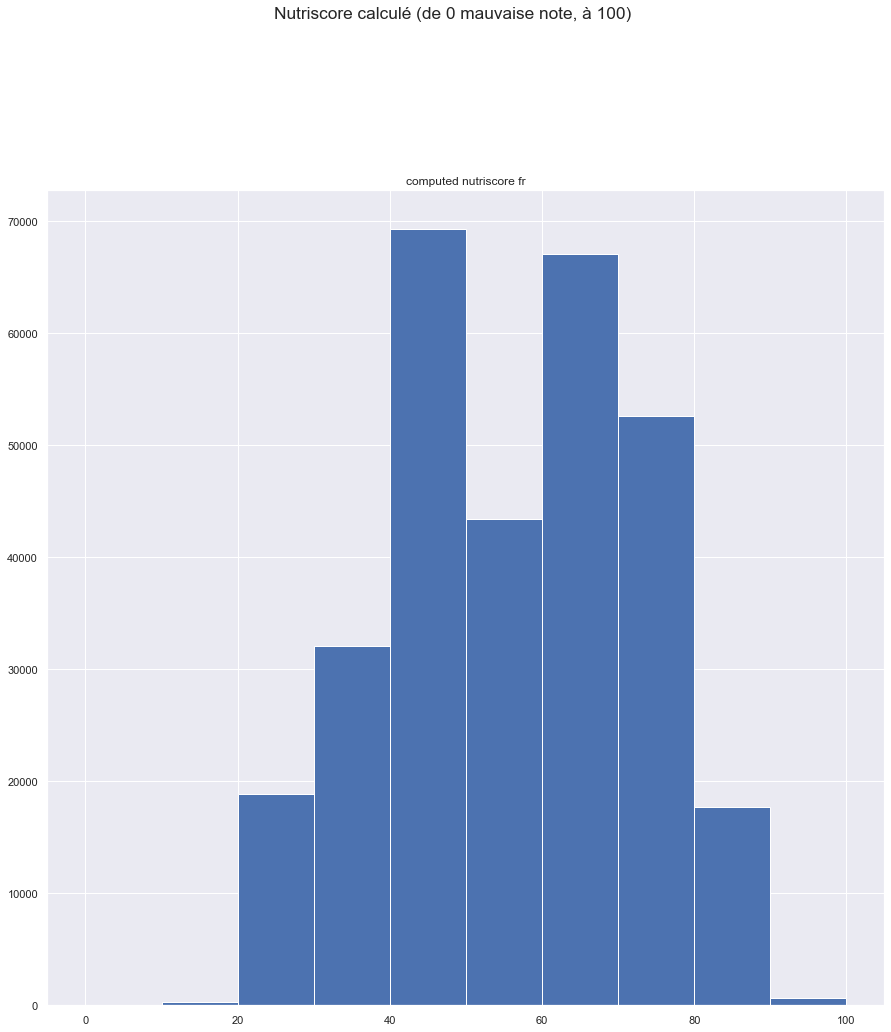

In [48]:
# On affiche finalement le nutriscore calculé
filtered_data.hist(column='computed nutriscore fr', figsize=[15, 15])
plt.suptitle('Nutriscore calculé (de 0 mauvaise note, à 100)', x=0.5, y=1.05, ha='center', fontsize='xx-large')

In [49]:
# Finalement on sauve le travail de nettoyage sous format feather pour le charger plus rapidement lors de l'exploration
filtered_data.reset_index(inplace=True)
filtered_data.to_feather('P3_cleaned.feather')